In [3]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
from os.path import join

import pymc3 as pm
import theano.tensor as tt
import theano

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Warm-up: softmax in theano

In [4]:
# declare variables and softmax
v = tt.vector('v', dtype='float32')
tau = tt.scalar('tau')
softmax = 1 / (1 + tt.exp(tau * (v[1] - v[0])))

func = theano.function([tau, v], [softmax])

<IPython.core.display.Javascript object>


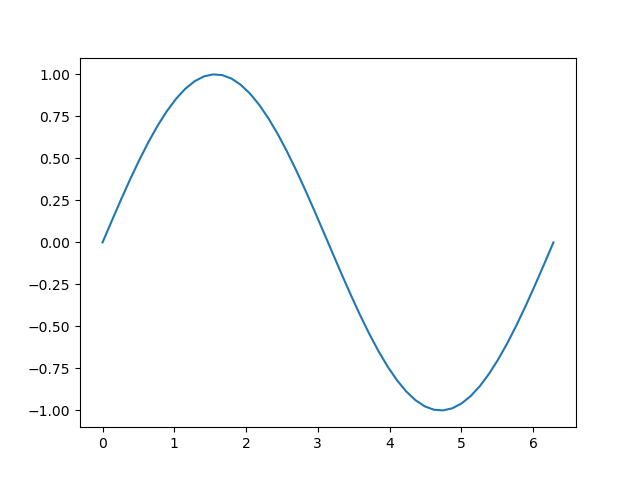

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [25]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update)
plt.show()

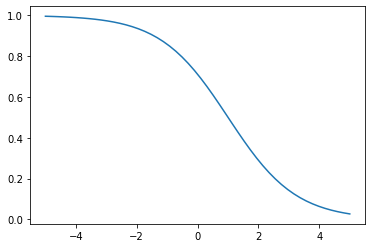

In [13]:
# run softmax for a couple of dummy 
res = []
va = 1.0
vb_values = np.linspace(-5, 5)
tau = 0.9

for v_ in [(va, x) for x in vb_values]:
    v = np.asarray(v_, dtype=np.float32)
    out = func(tau, v)
    res.append(out[0])
plt.plot(vb_values, res)

In [38]:
rl_mp = {}
df = pd.read_csv(join('_data', 'rl_mp.csv'))
rl_mp['choice'] = df.iloc[:, :100] - 1
rl_mp['reward'] = df.iloc[:, 100:]

nSubjects, nTrials = rl_mp['choice'].shape

In [40]:
nIter = 1000
nChains = 4
nWarmup = 1000

In: [ 1 -4], out: [array(0.5)]
In: [ 1 -3], out: [array(0.5)]
In: [ 1 -2], out: [array(0.5)]
In: [ 1 -1], out: [array(0.5)]
In: [1 0], out: [array(0.5)]
In: [1 1], out: [array(0.5)]
In: [1 2], out: [array(0.5)]
In: [1 3], out: [array(0.5)]
In: [1 4], out: [array(0.5)]


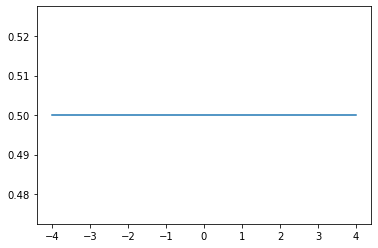

In [55]:
def softmax(tau, v):
    return 1 / (1 + tt.exp(v[1] - v[0]))

In [ ]:
with pm.Model() as pm:
    alpha = pm.Uniform('alpha', 0, 1)   
    tau = pm.Uniform('tau', 0, 3)
    
    v = tt.ivector('v')
    
    
    
    pm